In [5]:
import torch
import torch.nn as nn
import hiddenlayer as hl
from dataset import SimulationData
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import tqdm
from model import MainNet
import matplotlib as mpl


C:\Users\Pietro\anaconda3\envs\rans\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
dataset = SimulationData(stencilNum=500,samplePerStencil=50, fileNames=["aw=1.1_internal.csv","aw=1.2_internal.csv","aw=1.3_internal.csv", "aw=1.4_internal.csv","aw=1.5_internal.csv","aw=1.6_internal.csv","aw=1.7_internal.csv","aw=1.8_internal.csv","aw=1.9_internal.csv","aw=2.0_internal.csv"], override=False)


In [7]:
input_size1 = 4
hidden_size1_1 = 32
hidden_size1_2 = 64
output_size1 = 256

input_size2 = 256*5
hidden_size2_1 = 64
hidden_size2_2 = 32
output_size2 = 3

model_20 = MainNet(input_size1, hidden_size1_1, hidden_size1_2, output_size1, input_size2,hidden_size2_1, hidden_size2_2, output_size2)


In [8]:
model_20.load_state_dict(torch.load("./models/net_C_4.0=500_S=50_E=300.pth"))

<All keys matched successfully>

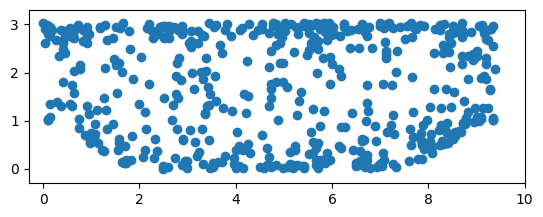

In [32]:
f, (ax1) = plt.subplots(1, 1, sharey=False)

ax1.set(xlim=[-0.3, 10], ylim=[-0.3, 3.3], aspect=1)
ax1.scatter(dataset.centers['aw=1.1_internal.csv'][:,0], dataset.centers['aw=1.1_internal.csv'][:,1])

In [11]:
criterion = nn.MSELoss()
def get_data(dataset, model, key):
    x = []
    y = []
    z = []
    true_z = []
    losses3 = []
    losses2 = []
    losses1 = []

    for i in range(len(dataset.file_x[key])):
        features =  dataset.file_x[key][i]
        labels =  dataset.file_y[key][i]
        #print(features)
        centerpoint = dataset.centers[key][i]
        true_z.append(labels[2].item())
        x.append(centerpoint[0].item())
        y.append(centerpoint[1].item())
        output1, output2, output3 = model(features.float())
        z.append(output3.item())
        labels[2].item()
        loss3 = criterion(output3.reshape(1), labels[2])
        loss2 = criterion(output2.reshape(1), labels[1])
        loss1 = criterion(output1.reshape(1), labels[0])

        losses3.append(loss3.item())
        losses2.append(loss2.item())
        losses1.append(loss1.item())

    losses3 = np.array(losses3)
    losses2 = np.array(losses2)
    losses1 = np.array(losses1)

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    true_z = np.array(true_z)
    
    return x, y, z, true_z, losses1, losses2, losses3


In [12]:
def contour(x, y, z, true_z, save=True, path='./images/countour.png'):
    from sklearn.preprocessing import Normalizer

    xi, yi = np.linspace(x.min(),x.max(), 3000), np.linspace(y.min(), y.max(), 3000)
    xi, yi = np.meshgrid(xi, yi)
    zi_predicted = scipy.interpolate.griddata((x, y), z, (xi, yi), method='linear')
    zi_true = scipy.interpolate.griddata((x, y), true_z , (xi, yi), method='linear')

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

    ax1.set(xlim=[-0.3, 11], ylim=[-0.3, 3.3], aspect=1)
    ax2.set(xlim=[-0.3, 11], ylim=[-0.3, 3.3], aspect=1)
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    
    ax1_plot = ax1.contourf(xi, yi, zi_true,levels=20)
    ax2_plot = ax2.contourf(xi, yi, zi_predicted,levels=20)
    plt.colorbar(ax1_plot,ax=[ax1, ax2], orientation='horizontal', shrink=1, location="top", label="ν", aspect=50)
    #plt.colorbar(ax2_plot,ax=[ax2], orientation='horizontal', shrink=1, location="top", label="ν", aspect=50)

    if(save):
        plt.savefig(path, dpi=1500)
    plt.show()

In [13]:
def losscontour(x, y, losses, save=True, path='./images/countour.png'):
    from sklearn.preprocessing import Normalizer

    xi, yi = np.linspace(x.min(),x.max(), 3000), np.linspace(y.min(), y.max(), 3000)
    xi, yi = np.meshgrid(xi, yi)
    lossi = scipy.interpolate.griddata((x, y), losses, (xi, yi), method='linear')
    f, (ax1) = plt.subplots(1, 1, sharey=False)
    ax1.set(xlim=[-0.3, 13], ylim=[-0.3, 3.3], aspect=1)
    
    ax1_plot = ax1.contourf(xi, yi, lossi, levels=50)
    plt.colorbar(ax1_plot,ax=[ax1], orientation='horizontal', shrink=1, location="top", label="ν", aspect=50)
    #plt.colorbar(ax2_plot,ax=[ax2], orientation='horizontal', shrink=1, location="top", label="ν", aspect=50)
    if(save):
        plt.savefig(path, dpi=1500)
    plt.show()

In [20]:
x, y, z, true_z, losses1, losses2, losses3 = get_data(dataset, model_20, 'aw=2.0_internal.csv')

In [2]:
#x, y, z, true_z = get_data(dataset2, model_300)
contour(x,y,z, true_z, path='./images/contours2.0/contour_all_1.7_300.png')

NameError: name 'contour' is not defined

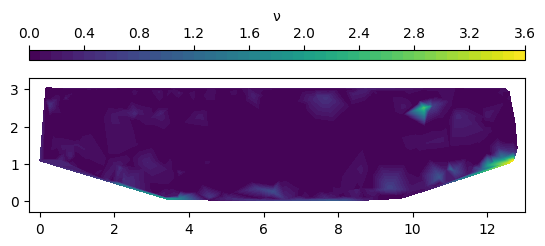

In [21]:
losscontour(x,y, losses3, path='./images/contours_LOSS/contour_all_2.0_300_loss3.png')

In [ ]:
plt.xlim(-0.3, 10.3)
plt.ylim(-0.3, 3.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.contourf(xi, yi, zi, levels=10)
plt.savefig("./images/contour_6_true.png", dpi=1500)

In [ ]:
plt.scatter(dataset.file_x['aw=1.1_internal.csv'][:,0], dataset.file_x['aw=1.1_internal.csv'][:,1])

In [ ]:
dataset.xdf_shuffled['aw=1.0_internal.csv']

In [ ]:
plt.scatter(dataset.x['aw=1.1_internal.csv'][:1000], dataset.xdf_shuffled['aw=1.1_internal.csv'][:1000])

In [ ]:
plt.scatter(dataset.xdf_shuffled['aw=1.1_internal.csv']["Cx"], dataset.xdf_shuffled['aw=1.1_internal.csv']["Cy"])

In [ ]:
dataset.xdf_shuffled['aw=1.0_internal.csv'][:10]